In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn import datasets
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
#数据获取
iris = datasets.load_iris()
x,y = iris.data,iris.target

## 1. Reduce the dimension via PCA and visualize the data

In [96]:
iris = datasets.load_iris()
x,y = iris.data,iris.target
# 降维
pca = PCA(n_components=2)
reduced_x = pca.fit_transform(x)

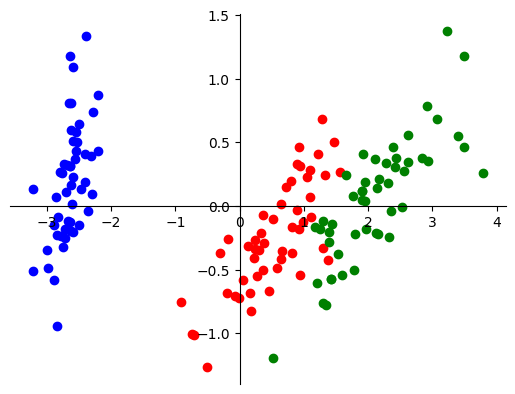

In [97]:
# 创建绘图
fig, ax = plt.subplots()
# 移动x轴到y=0
ax.spines['bottom'].set_position(('data', 0))  # 设置bottom spine的位置
# 移动y轴到x=0
ax.spines['left'].set_position(('data', 0))  # 设置left spine的位置
# 隐藏右边和顶部的轴
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(reduced_x[y==0,0],reduced_x[y==0,1],c='b')
ax.scatter(reduced_x[y==1,0],reduced_x[y==1,1],c='r')
ax.scatter(reduced_x[y==2,0],reduced_x[y==2,1],c='g')
plt.show()

## 2. Use the EM algorithm to cluster the data

In [398]:
from scipy.stats import multivariate_normal

# 增加正则化项来解决协方差矩阵不可逆的情况
def add_regularization(cov_matrix, lambda_reg=1e-5):
    # 给协方差矩阵添加一个小的正则化项
    return cov_matrix + lambda_reg * np.eye(cov_matrix.shape[0])

def is_invertible(cov_matrix, tol=1e-6):
    # 使用秩来判断矩阵是否接近奇异
    return np.linalg.matrix_rank(cov_matrix) == cov_matrix.shape[0]


class GMM:
    def __init__(self, n_components, n_iter=1000, tol=1e-4):
        self.n_components = n_components  # 高斯分布的数量
        self.n_iter = n_iter  # 迭代次数
        self.tol = tol  # 收敛阈值
        self.weights = None  # 各高斯分布的权重
        self.means = None  # 各高斯分布的均值
        self.covariances = None  # 各高斯分布的协方差矩阵
    
    def fit(self, X,centers=None,lambda_reg=1e-6):
        n_samples, n_features = X.shape

        # 初始化参数
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = np.array([np.cov(X.T) for _ in range(self.n_components)])
        if centers is not None:
            self.means = centers

        log_likelihood_old = 0

        log_likelihoods,means = [],[pca.transform(self.means)]
        for _ in range(self.n_iter):
            # E-step: 计算（每个样本属于每个高斯分布的概率）
            responsibilities = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
            
            # 计算对数似然函数值
            log_likelihood_new = np.sum(np.log(np.sum(responsibilities,axis=1)))

            log_likelihoods.append(log_likelihood_new)
            # 归一化
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)
            
            # M-step: 更新参数
            N_k = responsibilities.sum(axis=0)  # 每个组件的总责任度
            self.weights = N_k / n_samples  # 更新权重
            self.means = np.dot(responsibilities.T, X) / N_k[:, None]  # 更新均值
            means.append(pca.transform(self.means))
            for k in range(self.n_components):
                diff = X - self.means[k]
                self.covariances[k] = np.dot(responsibilities[:, k] * diff.T, diff) / N_k[k]  # 更新协方差

                # 使用改进的检查方法
                # while not is_invertible(self.covariances[k]):
                #     self.covariances[k] = add_regularization(self.covariances[k].copy(), lambda_reg)
                # print(f'{k} 可逆')   
                try:
                    multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
                except np.linalg.LinAlgError:
                    self.covariances[k] = add_regularization(self.covariances[k].copy(), lambda_reg)

            # 检查收敛条件
            if np.abs(log_likelihood_new - log_likelihood_old) < self.tol:
                # print(f"Converged at iteration {_ + 1}")
                break

            log_likelihood_old = log_likelihood_new
        self.log_likelihoods,self.mean = log_likelihoods,means
        return responsibilities

    def predict(self, X,lambda_reg=1e-6,norm=True):
        # 返回每个样本属于每个高斯分布的责任度
        responsibilities = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            try:
                responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
            except np.linalg.LinAlgError:  # 如果协方差矩阵不可逆，捕获错误
                # 添加正则化项，确保协方差矩阵是正定的
                # print(f"Warning: Covariance matrix is singular for cluster {k}. Adding regularization.")
                self.covariances[k] = add_regularization(self.covariances[k], lambda_reg)
                responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(X, mean=self.means[k], cov=self.covariances[k])
                
        if not norm: return responsibilities

        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        # return responsibilities.argmax(axis=1)  # 返回每个样本的最大责任度对应的标签
        
        return responsibilities


In [391]:
iris = datasets.load_iris()
x,y = iris.data,iris.target
# 训练GMM
gmm = GMM(n_components=3)
labels = gmm.fit(x)

llh,means = gmm.log_likelihoods,gmm.mean

# 预测每个样本属于哪个高斯分布
labels4EM = labels.argmax(axis=1)

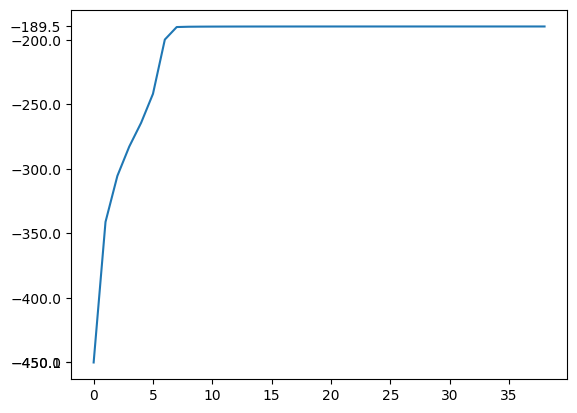

In [392]:
from math import ceil
plt.plot(range(len(llh)),llh)
plt.yticks([min(llh)]+np.arange(ceil(min(llh)/50)*50,ceil(max(llh)/50)*50,50).tolist()+[max(llh)])
plt.show()

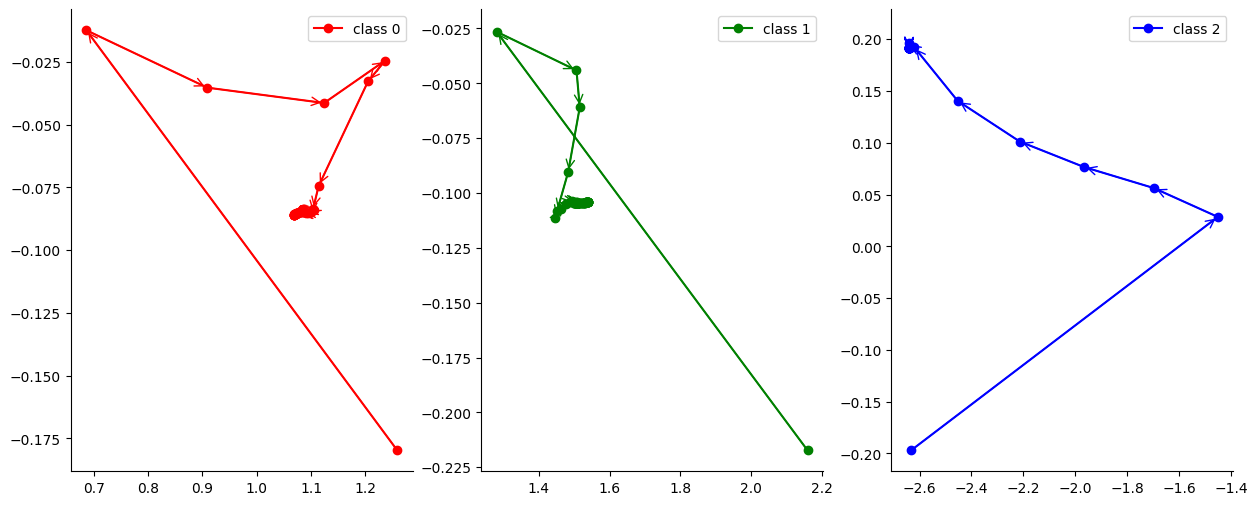

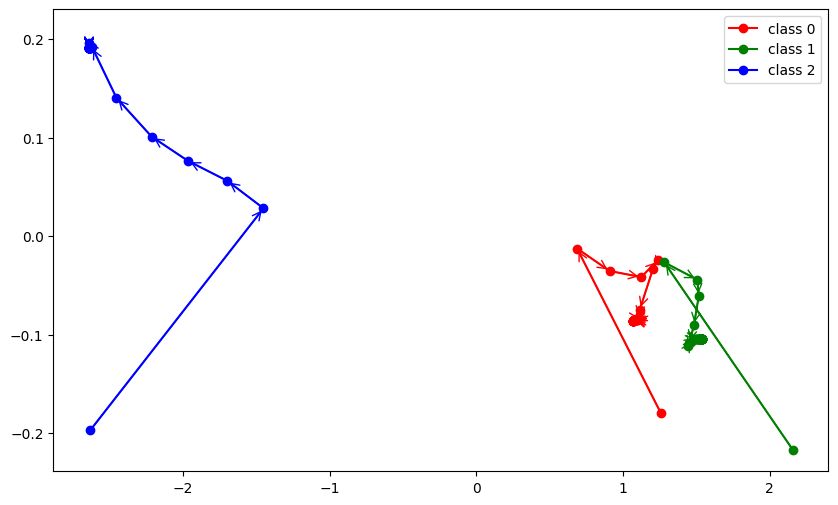

In [395]:
from matplotlib.patches import FancyArrowPatch
mu = np.array(means)
color = ['r','g','b']
# 创建绘图
fig, axes = plt.subplots(1,3,figsize=(15,6))
for j in range(3):
    x,y = mu[:,j,0],mu[:,j,1]
    ax = axes[j]
    ax.plot(x,y,marker='o',color=color[j],label=f'class {j}')
    for i in range(len(x) - 1):
        # 起点和终点
        start = (x[i], y[i])
        end = (x[i + 1], y[i + 1])
        # 计算箭头方向
        arrow = FancyArrowPatch(start, end, 
                                arrowstyle='->',  # 箭头样式
                                mutation_scale=15,  # 箭头大小
                                color=color[j])  # 箭头颜色
        ax.add_patch(arrow)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
plt.show()
fig,ax = plt.subplots(figsize=(10,6))
for j in range(3):
    x,y = mu[:,j,0],mu[:,j,1]
    ax.plot(x,y,marker='o',color=color[j],label=f'class {j}')
    for i in range(len(x) - 1):
        # 起点和终点
        start = (x[i], y[i])
        end = (x[i + 1], y[i + 1])
        # 计算箭头方向
        arrow = FancyArrowPatch(start, end, 
                                arrowstyle='->',  # 箭头样式
                                mutation_scale=15,  # 箭头大小
                                color=color[j])  # 箭头颜色
        ax.add_patch(arrow)
plt.legend()
plt.show()


## 3. Use variational inference to cluster the data with 𝐾 = 3

In [397]:
from matplotlib.colors import to_rgba
from sklearn.cluster import KMeans


# 将后验概率映射到RGB颜色
def get_color_for_responsibilities(responsibilities):
    # 归一化后验概率为RGB颜色，R、G、B分别表示每个类别的概率
    colors = np.array([to_rgba((responsibilities[i, 0], responsibilities[i, 1], responsibilities[i, 2]), alpha=0.7) for i in range(len(responsibilities))])
    return colors

def rgb_plot(colors,iteration):
    # 绘制数据点，颜色基于后验概率
    plt.scatter(reduced_x[:, 0], reduced_x[:, 1], c=colors, s=10)
    plt.title(f'GMM Clustering with CAVI (Posterior probabilities as colors) after{iteration}')
    plt.show()
# CAVI算法（变分推断）求解GMM参数
class GMM_CAVI:
    def __init__(self, n_components, n_iter=200):
        self.n_components = n_components
        self.n_iter = n_iter
    
    def fit(self, data,centers=None,is_plot=False,lambda_reg=1e-6,need_weights=False):
        n_samples, n_features = data.shape
            
        # 初始化变分参数
        self.gamma = np.random.rand(n_samples, self.n_components)
        new_means = old_means = data[np.random.choice(n_samples, self.n_components, replace=False)]
        if centers is not None:
            new_means = centers
        new_covs = old_covs = np.array([np.eye(n_features)] * self.n_components)
        new_weights = old_weights = np.ones(self.n_components) / self.n_components
        weights = [new_weights.copy()]
        iteration = 0
        while iteration ==0 or max(abs(new_covs-old_covs).max(),abs(new_means-old_means).max(),abs(new_weights-old_weights).max())>1e-5:
            old_covs,old_means,old_weights = new_covs.copy(),new_means.copy(),new_weights.copy()
        # for iteration in range(self.n_iter):
            # E-step: 计算每个数据点属于每个组件的责任（gamma）
            for i in range(n_samples):
                likelihoods = np.zeros(self.n_components)
                for k in range(self.n_components):
                    try:
                        likelihoods[k] = new_weights[k] * multivariate_normal.pdf(data[i], new_means[k], new_covs[k])
                    except np.linalg.LinAlgError:  # 如果协方差矩阵不可逆，捕获错误
                        # 添加正则化项，确保协方差矩阵是正定的
                        # print(f"Warning: Covariance matrix is singular for cluster {k}. Adding regularization.")
                        new_covs[k] = add_regularization(new_covs[k], lambda_reg)
                        likelihoods[k] = new_weights[k] * multivariate_normal.pdf(data[i], new_means[k], new_covs[k])
                self.gamma[i] = likelihoods / np.sum(likelihoods)
            
            # M-step: 更新组件的均值、协方差和权重
            for k in range(self.n_components):
                # 更新权重
                N_k = np.sum(self.gamma[:, k])
                new_weights[k] = N_k / n_samples
                
                # 更新均值
                new_means[k] = np.dot(self.gamma[:, k], data) / N_k
                
                # 更新协方差
                diff = data - new_means[k]
                new_covs[k] = np.dot(self.gamma[:, k] * diff.T, diff) / N_k
            weights.append(new_weights.copy())

            iteration += 1
            # 每100次迭代输出一次结果
            if iteration == 1 or iteration % 10 == 0:
                responsibilities = self.gamma.copy()
                if is_plot:
                    color = get_color_for_responsibilities(responsibilities)
                    rgb_plot(color,iteration)
            # print(iteration)

        self.means,self.weights = new_means,new_weights
        self.covariances = new_covs.copy()
                    
        if need_weights:
                return np.argmax(self.gamma,axis=1),weights,iteration

        return responsibilities
    
    def predict(self, data,lambda_reg=1e-6,norm=True):
        n_samples = data.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for i in range(n_samples):
            likelihoods = np.zeros(self.n_components)
            for k in range(self.n_components):
                try:
                    likelihoods[k] = self.weights[k] * multivariate_normal.pdf(data[i], self.means[k], self.covariances[k])
                except np.linalg.LinAlgError:  # 如果协方差矩阵不可逆，捕获错误
                    # 添加正则化项，确保协方差矩阵是正定的
                    # print(f"Warning: Covariance matrix is singular for cluster {k}. Adding regularization.")
                    self.covariances[k] = add_regularization(self.covariances[k], lambda_reg)
                    likelihoods[k] = self.weights[k] * multivariate_normal.pdf(data[i], self.means[k], self.covariances[k])
            if norm:
                responsibilities[i] = likelihoods / np.sum(likelihoods)
            else:
                responsibilities[i] = likelihoods
        return responsibilities


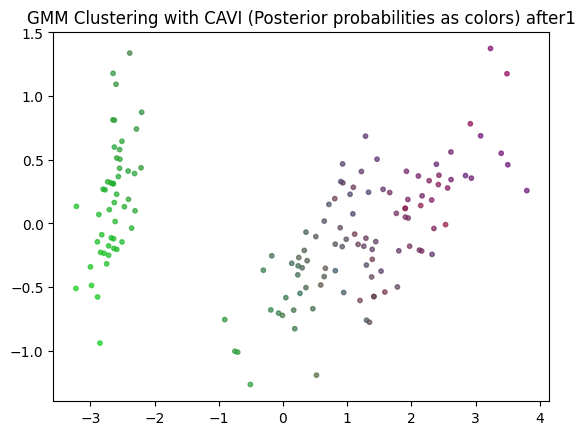

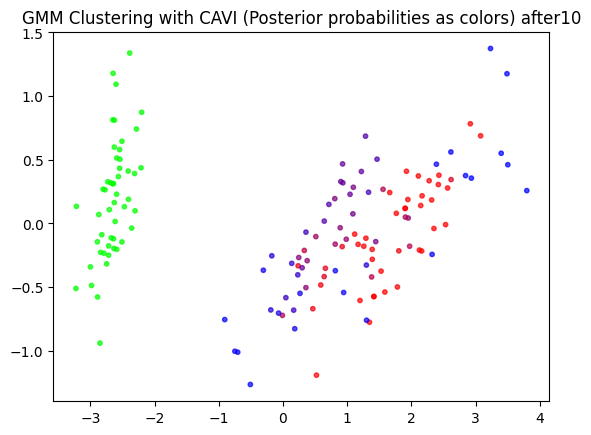

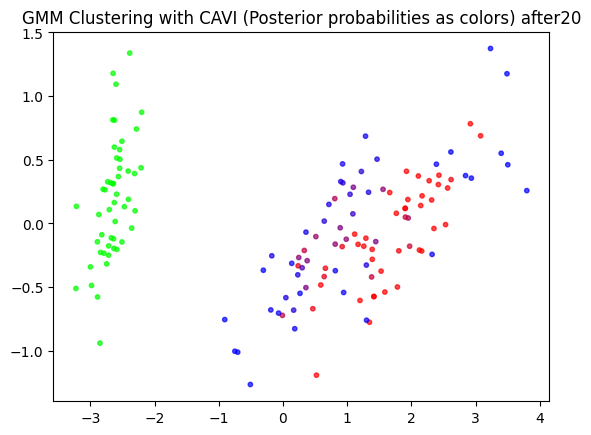

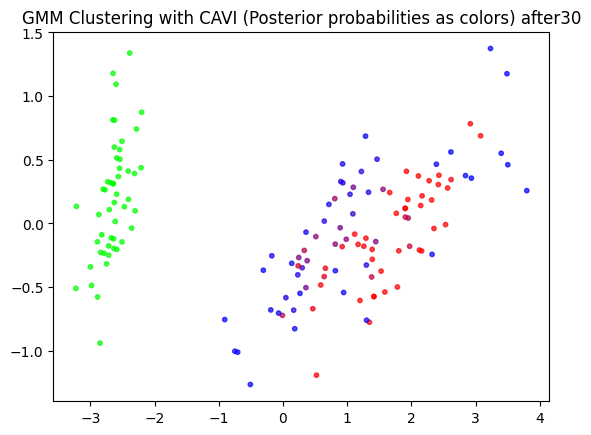

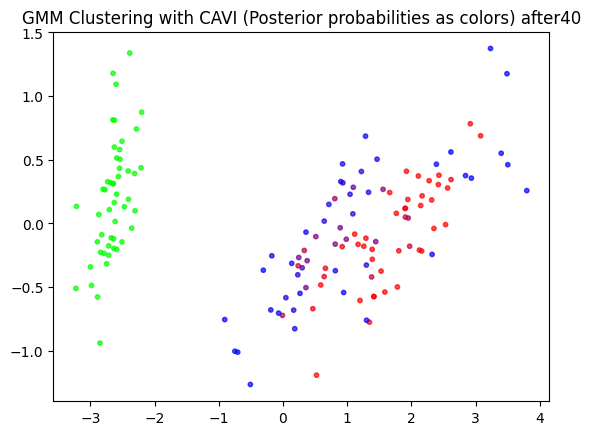

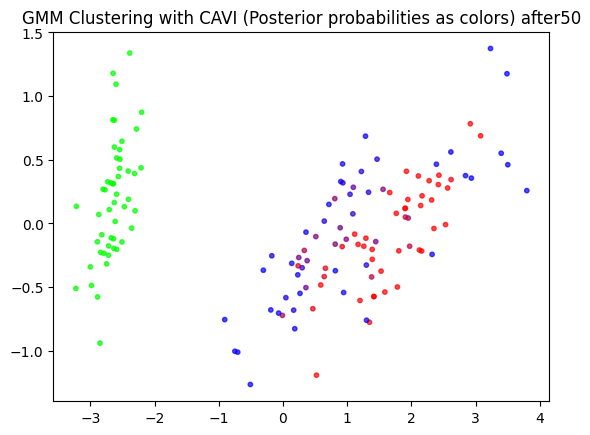

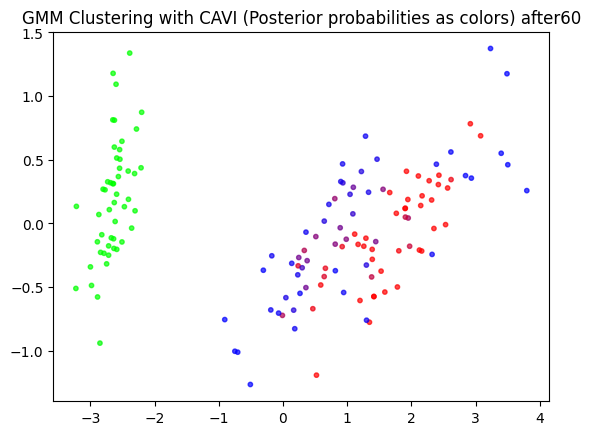

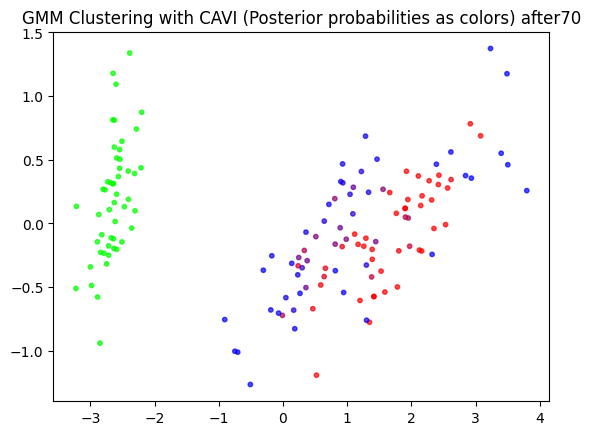

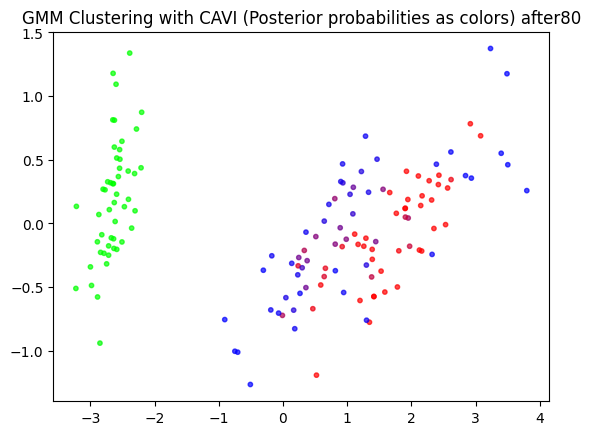

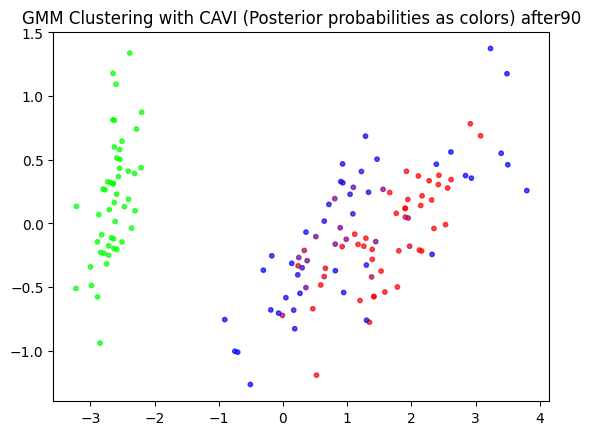

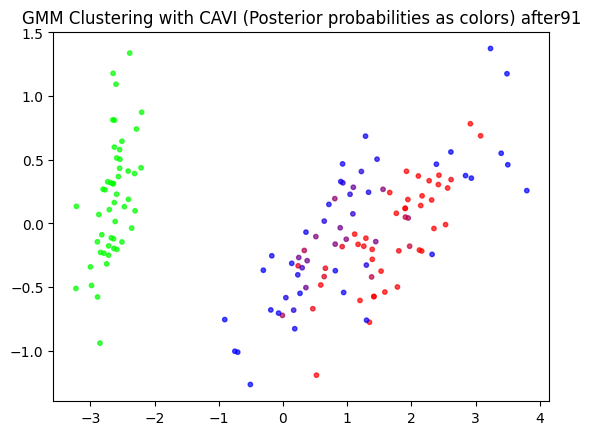

In [258]:
data = np.array(x)

# KMeans 聚类
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
centers = kmeans.cluster_centers_

#实例化并拟合模型
gmm = GMM_CAVI(n_components=3)
labels4VI,weights,num_iterations = gmm.fit(data,is_plot=True,need_weights=True)

# 可视化结果：根据后验概率着色
responsibilities = gmm.predict(x)

# 获取每个点的颜色
colors = get_color_for_responsibilities(responsibilities)
rgb_plot(colors,num_iterations)

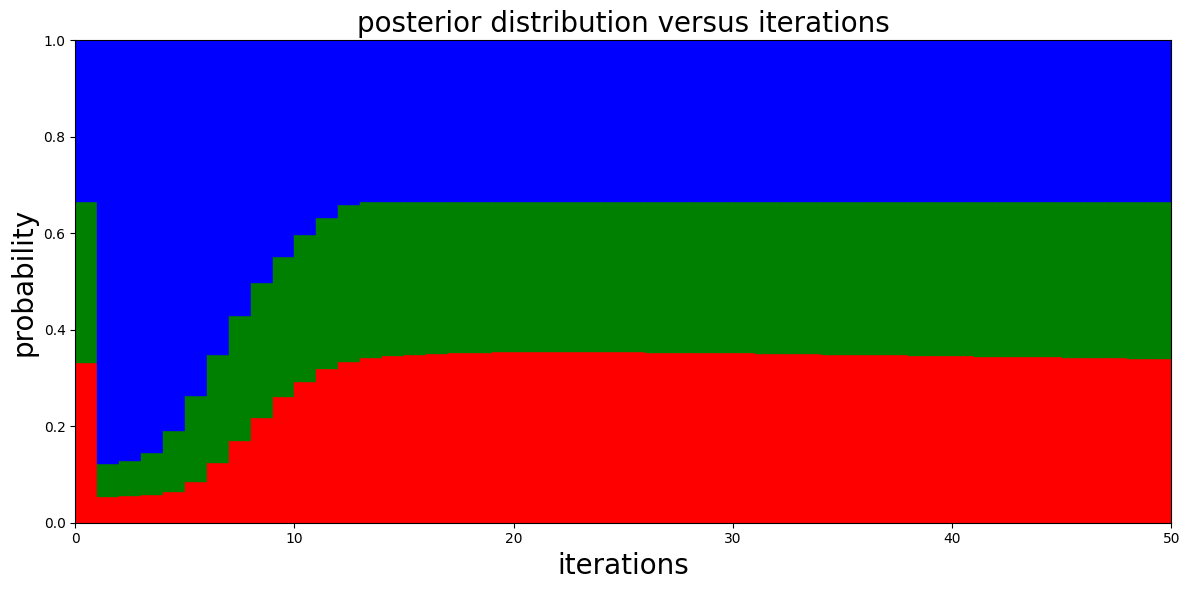

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你有100个proportions，每个proportion是一个包含三种颜色比例的列表
num_rectangles = 50  # 总共有100个格子
proportions = np.array(weights)

colors = ['red', 'green', 'blue']  # 三种颜色

# 创建一个画布
fig, ax = plt.subplots(figsize=(12, 6))  # 图形大小

# 绘制每个小长方形
for i in range(num_rectangles):
    y_positions = np.cumsum([0] + proportions[i,:-1].tolist())  # 计算每个颜色块的起始位置
    height = proportions[i]  # 获取当前格子中的比例

    # 绘制颜色条的每个部分
    for j, (y, h, color) in enumerate(zip(y_positions, height, colors)):
        ax.add_patch(plt.Rectangle((i, y), 1, h, color=color))  # 绘制矩形

# 设置坐标轴
ax.set_xlim(0, num_rectangles)  # x 轴的范围为 0 到 100
ax.set_ylim(0, 1)  # y 轴的范围为 0 到 1
ax.set_xlabel("iterations",fontdict={'fontsize': 20})  # x 轴标签
ax.set_ylabel("probability",fontdict={'fontsize': 20})  # y 轴标签

# 添加标题
plt.title('posterior distribution versus iterations',fontdict={'fontsize': 20})

# 显示图形
plt.tight_layout()
plt.show()


## Use Gibbs sampling to cluster the data with 𝐾 = 3

In [468]:
def add_regularization(cov_matrix, lambda_reg):
    """对协方差矩阵添加正则化项"""
    if len(cov_matrix.shape) == 1:
        print(cov_matrix)
    try:
        ans = cov_matrix + lambda_reg * np.eye(cov_matrix.shape[0])
    except IndexError :
        print(cov_matrix)
    return cov_matrix + lambda_reg * np.eye(cov_matrix.shape[0])  # 添加对角矩阵正则化

class GMM_GS():
    def __init__(self,n_components,num_iterations=1000):
        self.K = self.n_components = n_components
        self.iter = num_iterations
    # Gibbs采样对GMM进行分类
    def is_valid_matrix(self,matrix):
        return not np.any(np.isnan(matrix)) and not np.any(np.isinf(matrix))

    # Gibbs采样对GMM进行分类
    def fit(self, data, iterations=1000, lambda_reg=1e-6,return_ans = False,centers = None):
        N, D = data.shape  # 数据的维度和样本数
        K = self.K
        # 初始化
        # KMeans 聚类
        mu = data[np.random.choice(N, self.n_components, replace=False)]  # 随机初始化每个簇的均值
        cov = [np.eye(D)] * K  # 初始化每个簇的协方差矩阵为单位矩阵
        pi = np.ones(K) / K  # 初始化混合权重为均匀分布
        z = np.random.randint(K, size=N)  # 随机初始化每个数据点的标签
        if centers is not None:
            mu = centers
            
        # 存储结果
        z_samples = []
        mu_samples = []
        cov_samples = []
        pi_samples = []

        for iteration in range(iterations):
            # 1. 类别标签采样
            for n in range(N):
                probs = np.zeros(K)
                for k in range(K):
                    try:
                        probs[k] = pi[k] * multivariate_normal.pdf(data[n], mean=mu[k], cov=cov[k])
                    except ValueError:
                        probs[k] = pi[k] * multivariate_normal.pdf(np.zeros(D),mean=np.zeros(D),cov=np.identity(D))
                probs /= np.sum(probs)  # 归一化
                z[n] = np.random.choice(K, p=probs)

            # 2. 参数采样
            for k in range(K):
                # 采样均值
                X_k = data[z == k]
                if X_k.shape[0] > 0:
                    mu[k] = np.mean(X_k, axis=0)

                # 采样协方差
                X_k_centered = X_k - mu[k]                    
                cov[k] = np.cov(X_k_centered, rowvar=False)
                
                #如果第k个类的点的个数小于等于1
                if len(X_k)<=1 : cov[k] = np.identity(D)

                # # 检查协方差矩阵是否可逆，如果不可逆，添加正则化项
                try:
                    np.linalg.inv(cov[k])
                except np.linalg.LinAlgError:
                    # print(f"Warning: Covariance matrix is singular for cluster {k}. Adding regularization.")
                    cov[k] = add_regularization(cov[k], lambda_reg)

                # cov[k] = add_regularization(cov[k], lambda_reg)

                # 采样混合权重
                pi[k] = X_k.shape[0] / N

            # 记录参数和标签
            pi_samples.append(pi.copy())
            z_samples.append(z.copy())
            mu_samples.append(mu.copy())
            cov_samples.append(cov.copy())
            # if iteration % 10 == 0:
            #     print(f"Iteration {iteration}/{iterations}")
        self.mu_samples, self.cov_samples, self.z_samples, self.pi_samples = mu_samples, cov_samples, z_samples, pi_samples
        # 通过gibbs sampling之后得到的参数
        self.means, self.covs, self.weights = self.estimate_parameters()
        self.covariances = self.covs.copy()
        # 返回对y_train的预测
        if return_ans:
            return np.argmax(self.predict(data), axis=1)
        return self.predict(data)
    
    def estimate_parameters(self,burn_in_period=50):
        mu_samples, cov_samples, pi_samples = self.mu_samples[burn_in_period:], self.cov_samples[burn_in_period:], self.pi_samples[burn_in_period:]
        # 初始化估计值
        mu_hat = np.mean(mu_samples, axis=0)  # 对每次采样的均值进行平均
        cov_hat = np.mean(cov_samples, axis=0)  # 对每次采样的协方差矩阵进行平均
        pi_hat = np.mean(pi_samples, axis=0)  # 对每次采样的混合权重进行平均

        return mu_hat, cov_hat, pi_hat
    
    def predict(self, data,lambda_reg=1e-6,norm=True):
        n_samples,D = data.shape[0],data.shape[1]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for i in range(n_samples):
            likelihoods = np.zeros(self.n_components)
            for k in range(self.n_components):
                    # try:
                    #     likelihoods[k] = self.pi[k] * multivariate_normal.pdf(data[i], mean=self.means[k], cov=self.covs[k])
                    # except ValueError:
                    #     likelihoods[k] = self.pi[k] / np.power(2*np.pi,2)
                likelihoods[k] = self.weights[k] * multivariate_normal.pdf(data[i], mean=self.means[k], cov=self.covs[k])
            if norm:
                responsibilities[i] = likelihoods / np.sum(likelihoods)
            else:
                responsibilities[i] = likelihoods
        
        return responsibilities
    

    

# 可视化数据和分类结果
def plot_results(z_samples, mu_samples):
    fig,ax = plt.subplots(figsize=(8,6))
    # 移动x轴到y=0
    ax.spines['bottom'].set_position(('data', 0))  # 设置bottom spine的位置
    # 移动y轴到x=0
    ax.spines['left'].set_position(('data', 0))  # 设置left spine的位置
    # 隐藏右边和顶部的轴
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    colors_map = np.array([[1, 0, 0],  # 红色 (类别 0)
                        [0, 1, 0],  # 绿色 (类别 1)
                        [0, 0, 1]])  # 蓝色 (类别 2)
    
    ax.scatter(reduced_x[:, 0], reduced_x[:, 1], c=colors_map[z_samples], cmap='viridis', s=30, alpha=0.5)
    ax.scatter(mu_samples[:, 0], mu_samples[:, 1], c='red', marker='x', s=100, label="Cluster Centers")
    plt.title("Gibbs Sampling for GMM Classification")
    plt.legend()
    plt.show()

In [529]:
from scipy.stats import multivariate_normal, wishart, dirichlet
def add_regularization(cov_matrix, lambda_reg):
    """
    对协方差矩阵添加正则化项，确保其正定性
    """
    return cov_matrix + lambda_reg * np.eye(cov_matrix.shape[0])

class GMM_GibbsSampler:
    def __init__(self, n_components, num_iterations=1000, lambda_reg=1e-6, burn_in=100):
        """
        初始化GMM吉布斯采样器

        参数:
        - n_components: 混合组件数量K
        - num_iterations: 总迭代次数
        - lambda_reg: 协方差矩阵的正则化参数
        - burn_in: 烧入期（丢弃的前几次迭代）
        """
        self.K = n_components
        self.num_iterations = num_iterations
        self.lambda_reg = lambda_reg
        self.burn_in = burn_in

    def fit(self, data):
        """
        对数据进行吉布斯采样以拟合GMM

        参数:
        - data: 输入数据，形状为(N, D)

        返回:
        - self
        """
        N, D = data.shape
        K = self.K

        # 使用KMeans进行初始化
        # kmeans = KMeans(n_clusters=K)
        # labels = kmeans.fit_predict(data)
        # mu = kmeans.cluster_centers_
        mu = data[np.random.choice(N, K, replace=False)]# 随机初始化每个簇的均值
        labels = np.random.choice(K,N,replace=True)
        # 初始化协方差矩阵为各簇的样本协方差或单位矩阵
        cov = []
        for k in range(K):
            X_k = data[labels == k]
            if X_k.shape[0] > 1:
                cov_k = np.cov(X_k, rowvar=False) + self.lambda_reg * np.eye(D)
            else:
                cov_k = np.eye(D)
            cov.append(cov_k)

        # 初始化混合权重为均匀分布
        pi = np.ones(K) / K

        # 初始化簇分配
        z = labels.copy()

        # 设置先验参数
        mu0 = np.mean(data, axis=0)          # 均值先验设为数据的全局均值
        kappa0 = 1.0                          # 增加均值先验的缩放参数
        nu0 = D + 2                           # 协方差矩阵的Inverse-Wishart先验自由度
        Psi0 = np.cov(data, rowvar=False) + 1e-6 * np.eye(D)  # 协方差矩阵的Inverse-Wishart先验尺度矩阵

        alpha = np.ones(K)  # Dirichlet先验参数，可以适当增加以防止pi[k]过小

        # 存储采样结果
        z_samples = []
        mu_samples = []
        cov_samples = []
        pi_samples = []

        for it in range(self.num_iterations):
            # 步骤1: 采样簇分配 z
            for n in range(N):
                probs = np.zeros(K)
                for k in range(K):
                    try:
                        probs[k] = pi[k] * multivariate_normal.pdf(data[n], mean=mu[k], cov=cov[k] + 1e-6 * np.eye(D))
                    except np.linalg.LinAlgError:
                        # 如果协方差矩阵不可逆，添加正则化
                        cov_k_reg = add_regularization(cov[k], self.lambda_reg)
                        probs[k] = pi[k] * multivariate_normal.pdf(data[n], mean=mu[k], cov=cov_k_reg)
                probs /= np.sum(probs)  # 归一化
                z[n] = np.random.choice(K, p=probs)

            # 步骤2: 采样混合权重 pi
            counts = np.array([np.sum(z == k) for k in range(K)])
            pi = dirichlet.rvs(alpha=counts + alpha)[0]

            # 步骤3: 采样均值 mu
            for k in range(K):
                X_k = data[z == k]
                n_k = X_k.shape[0]
                if n_k > 0:
                    # 后验参数
                    kappa_n = kappa0 + n_k
                    mu_n = (kappa0 * mu0 + np.sum(X_k, axis=0)) / kappa_n
                    Sigma_n = cov[k] / kappa_n
                    try:
                        mu[k] = np.random.multivariate_normal(mu_n, Sigma_n)
                    except np.linalg.LinAlgError:
                        # 如果Sigma_n不可逆，添加正则化
                        Sigma_n_reg = add_regularization(Sigma_n, self.lambda_reg)
                        mu[k] = np.random.multivariate_normal(mu_n, Sigma_n_reg)
                else:
                    # 没有数据点属于该簇，使用先验均值
                    mu[k] = np.random.multivariate_normal(mu0, cov[k] / kappa0)

            # 步骤4: 采样协方差矩阵 Sigma
            for k in range(K):
                X_k = data[z == k]
                n_k = X_k.shape[0]
                if n_k > 0:
                    # 后验参数
                    S = np.dot((X_k - mu[k]).T, (X_k - mu[k]))
                    Psi_n = Psi0 + S
                    nu_n = nu0 + n_k
                    try:
                        # 采样精度矩阵 W ~ Wishart(nu_n, Psi_n^{-1})
                        W = wishart.rvs(df=nu_n, scale=np.linalg.inv(Psi_n))
                        # 采样协方差矩阵 Sigma = W^{-1}
                        Sigma = np.linalg.inv(W)
                    except np.linalg.LinAlgError:
                        # 如果Psi_n不可逆，添加正则化
                        Psi_n_reg = add_regularization(Psi_n, self.lambda_reg)
                        W = wishart.rvs(df=nu_n, scale=np.linalg.inv(Psi_n_reg))
                        Sigma = np.linalg.inv(W)
                    # 添加正则化
                    Sigma = add_regularization(Sigma, self.lambda_reg)
                    cov[k] = Sigma
                else:
                    # 没有数据点属于该簇，使用先验协方差
                    try:
                        W = wishart.rvs(df=nu0, scale=np.linalg.inv(Psi0))
                        Sigma = np.linalg.inv(W)
                    except np.linalg.LinAlgError:
                        # 如果Psi0不可逆，添加正则化
                        Psi0_reg = add_regularization(Psi0, self.lambda_reg)
                        W = wishart.rvs(df=nu0, scale=np.linalg.inv(Psi0_reg))
                        Sigma = np.linalg.inv(W)
                    Sigma = add_regularization(Sigma, self.lambda_reg)
                    cov[k] = Sigma

            # 记录采样结果
            z_samples.append(z.copy())
            mu_samples.append(mu.copy())
            cov_samples.append(cov.copy())
            pi_samples.append(pi.copy())

            # 打印进度
            # if (it + 1) % 100 == 0 or it == 0:
            #     print(f"迭代 {it + 1}/{self.num_iterations} 完成")

        # 丢弃烧入期的采样
        self.z_samples = z_samples[self.burn_in:]
        self.mu_samples = mu_samples[self.burn_in:]
        self.cov_samples = cov_samples[self.burn_in:]
        self.pi_samples = pi_samples[self.burn_in:]

        # 估计最终参数
        self.mu_ = np.mean(self.mu_samples, axis=0)
        self.cov_ = np.mean(self.cov_samples, axis=0)
        self.pi_ = np.mean(self.pi_samples, axis=0)
        self.covariances,self.weights,self.means = self.cov_.copy(),self.pi_,self.mu_.copy()

        return self

    def predict_proba(self, data,norm=True):
        """
        计算每个数据点属于每个簇的后验概率

        参数:
        - data: 输入数据，形状为(N, D)

        返回:
        - responsibilities: 后验概率，形状为(N, K)
        """
        N, D = data.shape
        K = self.K
        responsibilities = np.zeros((N, K))
        for k in range(K):
            try:
                responsibilities[:, k] = self.pi_[k] * multivariate_normal.pdf(data, mean=self.mu_[k], cov=self.cov_[k] + 1e-6 * np.eye(D))
            except np.linalg.LinAlgError:
                # 如果协方差矩阵不可逆，添加正则化
                cov_k_reg = add_regularization(self.cov_[k], self.lambda_reg)
                responsibilities[:, k] = self.pi_[k] * multivariate_normal.pdf(data, mean=self.mu_[k], cov=cov_k_reg)
        if norm:
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def predict(self, data,norm=True):
        """
        预测每个数据点的簇标签

        参数:
        - data: 输入数据，形状为(N, D)

        返回:
        - labels: 簇标签，形状为(N,)
        """
        responsibilities = self.predict_proba(data,norm=norm)
        if not norm:
            return responsibilities
        labels = np.argmax(responsibilities, axis=1)
        return labels


In [533]:
gmm = GMM_GibbsSampler(3)
gmm.fit(x)
labels4GS = gmm.predict(x)

C:\Users\24274\AppData\Local\Temp\ipykernel_30484\3508909930.py:137: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(reduced_x[:, 0], reduced_x[:, 1], c=colors_map[z_samples], cmap='viridis', s=30, alpha=0.5)


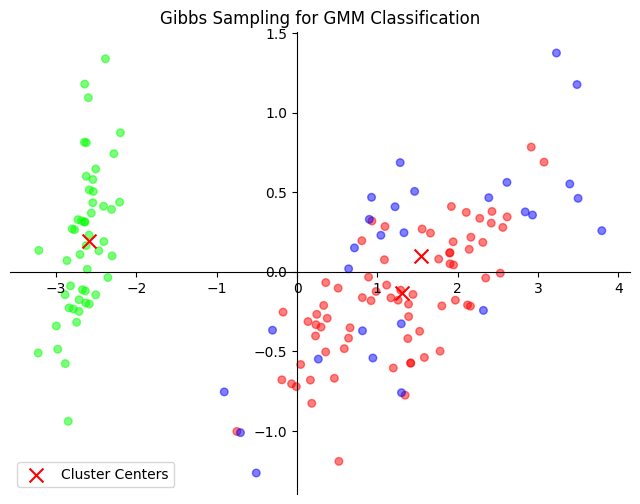

In [534]:
mu = pca.transform(gmm.mu_)
plot_results(labels4GS,mu)

## 5. Validate the clustering accuracy in terms of Rand index

In [53]:
#定义RandIndex类
class RandIndex():
    def __init__(self):
        pass

    def __call__(self,y_true,y_pred):
        self.rand_index = self.calculate(y_true,y_pred)
        return self.rand_index

    def calculate(self,y_true,y_pred):
        rand_index,n = 0, len(y_pred)
        for first in range(n):
            for second in range(first+1,n):
                if (y_pred[first]==y_pred[second])==(y_true[first]==y_true[second]):
                    rand_index += 1
        rand_index /= n*(n-1)
        return rand_index*2

In [309]:
ri = RandIndex()
evels = np.zeros((3,5))
for i,model in enumerate([GMM,GMM_CAVI,GMM_GS]):
    for j in range(5):
        m = model(3)
        y_pred = m.fit(x).argmax(axis=1)
        evels[i,j] = ri(y,y_pred)

d:\download\anaconda\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\download\anaconda\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\24274\AppData\Local\Temp\ipykernel_30484\2783701544.py:58: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov[k] = np.cov(X_k_centered, rowvar=False)
d:\download\anaconda\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\download\anaconda\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [305]:
evels.mean(axis=1),evels.var(axis=1)

(array([0.83174944, 0.87298434, 0.81276063]),
 array([0.00147629, 0.01264671, 0.00523705]))

In [326]:
from sklearn.cluster import KMeans
ri = RandIndex()
evels = np.zeros((3,5))
for i,model in enumerate([GMM,GMM_CAVI]):
    for j in range(5):
        # 将数据点映射到KNN模型
        # KMeans 聚类
        kmeans = KMeans(n_clusters=3)
        kmeans.fit(x)
        centers = kmeans.cluster_centers_
        m = model(3)
        y_pred = m.fit(x,centers=centers).argmax(axis=1)
        evels[i,j] = ri(y,y_pred)

## 6. Bonus point

In [526]:
from sklearn.model_selection import KFold
from scipy.special import logsumexp

class cross_validation():
    def __init__(self,x,y):
        self.y,self.x = y,x

    def fit(self, models, Ks, k_fold=5, is_plot=False,lambda_reg=1e-6):
        x,y = self.x,self.y
        llhs = [[] for _ in range(len(models))]
        kf = KFold(n_splits=k_fold, shuffle=True)
        for i, model in enumerate(models):            
            print(f'it is the {i}th model \n ')
            for k in Ks:
                ri4k = 0
                model_specific = model(k)  # 假设 model 是一个可调用的类，传入 k
                print(f'when k = {k}')
                for train_index, val_index in kf.split(x):
                    X_train, X_val = x[train_index], x[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    model_specific.fit(X_train)  # 训练模型
                    y_pred = model_specific.predict(X_val,norm=False)  # 预测
                    if k==1: ri4k += np.sum(np.log(multivariate_normal.pdf(X_val, mean=model_specific.means[0], cov=model_specific.covariances[0])))
                    else:
                        # print(y_pred.shape,model_specific.weights.shape)
                        ri4k += np.sum(np.log(np.sum(y_pred, axis=1)))
                        print(ri4k)
                ri4k /= k_fold
                llhs[i].append(ri4k)

        # 画图
        if is_plot:
            fig, ax = plt.subplots(figsize=(8, 6))
            for i, model in enumerate(models):
                ax.plot(Ks, llhs[i], label=f'{model.__name__ if hasattr(model, "__name__") else str(model)}')
            plt.legend()
            plt.show()

        return llhs


it is the 0th model 
 
when k = 1
when k = 2
-22.93635746323466
-61.66877243669761
-86.24549404183806
-109.28818516316038
-136.65234086790224
-170.96295007790832
-208.76753212160475
-223.08943147320252
-242.50009494336257
-273.36559638881374
when k = 3
-37.19603057619498
-48.19917244821078
-88.85629652421859
-119.09219930961018
-148.9065026592378
-179.76580385168248
-209.19392532079112
-229.99162008936787
-253.9183871434946
-277.15942418028226
when k = 4
-18.069297552212415
-38.58189919612823
-62.331216993545084
-89.11922118575063
-130.19235613795053
-146.61351314818586
-174.60278600802647
-209.07510012815416
-239.40161550651646
-272.6035172309903
when k = 5
-15.931785535960945
-54.8814187998139
-73.84036271694181
-105.19666417157904
-129.29201521542825
-157.44857767399543
-200.80450520202575
-241.61944704163943
-276.3920974924556
-309.33492069961477
when k = 6
-18.09113412313043
-59.653175907844606
-88.24156257706667
-106.23187041492645
-142.32167221297087
-178.52576666732585
-236.181

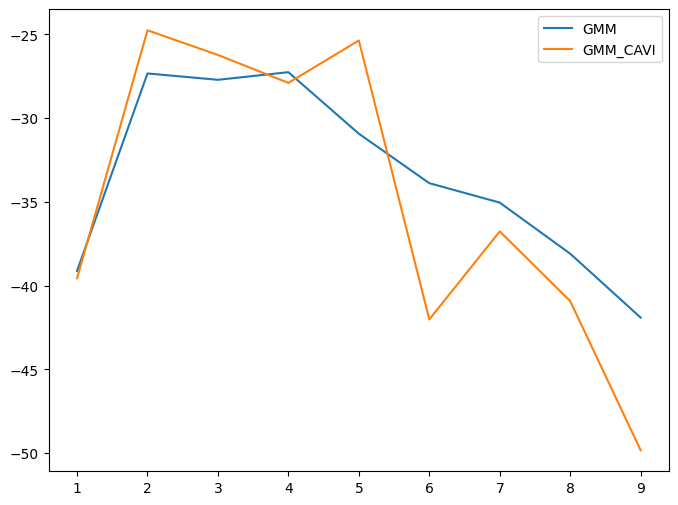

[[-39.12107224584984,
  -27.336559638881376,
  -27.715942418028227,
  -27.260351723099028,
  -30.933492069961478,
  -33.88391446741465,
  -35.04278365791972,
  -38.09277554025183,
  -41.905728858043645],
 [-39.56012514133983,
  -24.760401745170824,
  -26.233725613369113,
  -27.89953430168639,
  -25.3677527367256,
  -42.01446926938417,
  -36.76037016962441,
  -40.92040059153085,
  -49.821641379022246]]

In [535]:
iris = datasets.load_iris()
x,y = iris.data,iris.target
cv = cross_validation(x,y)

models = [GMM,GMM_CAVI]

# list of the number of the clusters
Ks = [i for i in range(1,10)]
# fit models
cv.fit(models,Ks,k_fold=10,is_plot=True)

it is the 0th model 
 
when k = 1
when k = 2
-37.796820688830365
-72.44678436390993
-101.75419019220965
-118.97928545107955
-147.53102383357592
-178.35616536218757
-212.2457716409939
-245.8778170899008
-271.5583152863801
-294.0595944379868
when k = 3
-33.91545415159935
-64.36910979206155
-88.00963274804562
-110.5678188255277
-124.5632556652636
-160.39818655504055
-198.82902451573514
-219.27929823041669
-240.01642906161518
-273.7398712744518
when k = 4
-24.349357697983784
-51.922219353585376
-87.33022172934281
-115.54109854467052
-129.59751701107277
-164.0813962809218
-192.630692317169
-214.90748142421583
-241.64223172330398
-267.72305408729966
when k = 5
-28.050503270797705
-47.70775475956777
-84.3078652461728
-103.26668425074806
-146.75903984475949
-173.45803258892602
-202.00011604839835
-238.2235043508792
-293.5207760631042
-312.3851746762092
it is the 1th model 
 
when k = 1
when k = 2
-32.90167867125357
-56.473603345489785
-87.7837368902243
-106.30862486907833
-146.2176697752242
-1

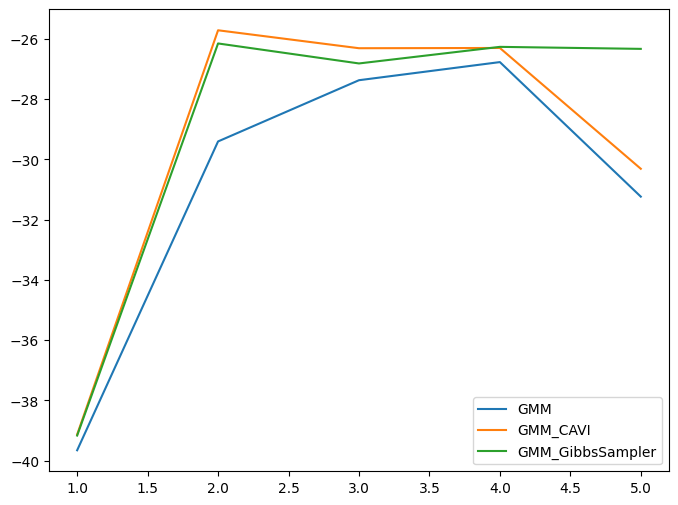

[[-39.658382353711254,
  -29.40595944379868,
  -27.37398712744518,
  -26.772305408729967,
  -31.23851746762092],
 [-39.13432435557467,
  -25.716216256435068,
  -26.31191814837287,
  -26.303747532075555,
  -30.31345177750356],
 [-39.1689810278803,
  -26.153770793531333,
  -26.817318550765314,
  -26.266678270819533,
  -26.33342235178506]]

In [532]:
iris = datasets.load_iris()
x,y = iris.data,iris.target
cv = cross_validation(x,y)

models = [GMM,GMM_CAVI,GMM_GS]
models = [GMM,GMM_CAVI,GMM_GibbsSampler]

# list of the number of the clusters
Ks = [i for i in range(1,6)]
# fit models
cv.fit(models,Ks,k_fold=10,is_plot=True)